# Gridworld Environments
Gridworld environments are built to be OpenAI gym envrionments, instantiated with the call 

`gym.make(<name of environment>)` 

where the environment name is a string. You can see which envs have been registered to be called this way in
` ./modules/Envs/gym-grid/__init__.py `



In [2]:
import gym

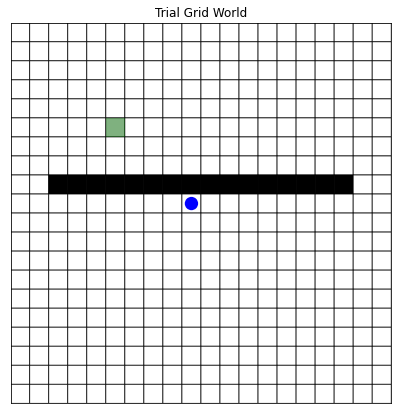

In [3]:
env = gym.make('gym_grid:gridworld-v4')

In [4]:
# valid states 
print(f'State space (total number of states): {env.nstates}')
print(f'--> States which the agent can occupy: {len(env.useable)}\n--> States the agent cannot occupy: {len(env.obstacles_list)}')
print('* print env.useable for valid states \n* print env.obstacles_2D for invalid states')
# available actions
print(f'\nAction space (number of actions): {env.action_space}')
print(f'--> Available actions: {env.action_list} \n--> Action Dictionary: {env.action_dict}')

# transition matrix
print(f'\nTransition matrix: {env.P.shape} \n* print env.P for whole transition matrix')

# reward function
print(f'\nRewards at {env.rewards} \n* Rewrite reward function with env.set_reward(dictionary_of_rewards)')
print(f'Each non-reward step carries penalty: {env.step_penalization}')
print(f'Rewarded action: {env.rwd_action} \n* If specific action is rewarded, \n   env.R.shape = (env.nstates x env.n_actions) \n  else, env.R.shape = env.nstates')
print(f'Reward function: {env.R.shape} \n* print env.R for whole reward function')

State space (total number of states): 400
--> States which the agent can occupy: 384
--> States the agent cannot occupy: 16
* print env.useable for valid states 
* print env.obstacles_2D for invalid states

Action space (number of actions): Discrete(4)
--> Available actions: ['Down', 'Up', 'Right', 'Left'] 
--> Action Dictionary: {'D': 0, 'U': 1, 'R': 2, 'L': 3}

Transition matrix: (4, 400, 400) 
* print env.P for whole transition matrix

Rewards at {(5, 5): 10} 
* Rewrite reward function with env.set_reward(dictionary_of_rewards)
Each non-reward step carries penalty: -0.01
Rewarded action: None 
* If specific action is rewarded, 
   env.R.shape = (env.nstates x env.n_actions) 
  else, env.R.shape = env.nstates
Reward function: (400,) 
* print env.R for whole reward function


In [5]:
# moves are made in the environment with 
# integer values representing actions

#env.set_state(100) # can set state with integer value

print(f'State is {env.state}')
action = 0 # Down
next_state, reward, done, debug_info = env.step(action)
print(f'Agent takes action {action}')
print(f'Agent observes reward {reward}')
print(f'State is now {next_state}')

State is 189
Agent takes action 0
Agent observes reward -0.01
State is now 209


# Agents
Agent class is a container which handles interaction with the environment. The class is built to use a neural network for action selection, but can be modified to use a tabular solution method. 

The agent class is defined in `./modules/Agents/__init__.py`

It takes a pytorch network object as input (several types defined in `./modules/Agents/Networks/`). New networks should be written in stand alone files and imported by `./modules/Agents/Networks/__init__.py` so that everything can just be imported from modules.Agents.Networks 

In [6]:
# import a fully connected deep actor-critic network
from modules.Agents.Networks import ActorCritic as Network 

network = Network(input_dims=[env.nstates], fc1_dims=200, 
                  fc2_dims=200, output_dims=env.action_space.n, 
                  lr=0.001)
print(network)

fully_connected_AC_network(
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (pol): Linear(in_features=200, out_features=4, bias=True)
  (val): Linear(in_features=200, out_features=1, bias=True)
)


In [7]:
# import memory module 
from modules.Agents.EpisodicMemory import EpisodicMemory as Memory

memory = Memory(entry_size=env.action_space.n,
                cache_limit=env.nstates)

Agents take a dictionary of state representations to convert numerical state given by the environment to an appropriate input for the neural network. 

__This should be changed in the future!!__

In [8]:
## make some onehot representations
import numpy as np 
state_reps = {}
for i in range(env.nstates):
    vec = np.zeros(env.nstates)
    vec[i] = 1
    state_reps[i] = vec

In [9]:
# package network in agent 
from modules.Agents import Agent

model_free_agent = Agent(network, state_representations=state_reps) # memory defaults to None
memory_agent     = Agent(network, memory, state_representations=state_reps)

Agent uses model-free network module for action selection
Agent uses episodic memory module for action selection


In [10]:
state = env.state
print(f'State: {state}')
# get onehot representation of state
obs = model_free_agent.get_state_representation(state)

# by default the Agent with no memory module selects actions from 
# the network output (policy)
MF_action, _, __ = model_free_agent.get_action(obs)
# by default the Agent *WITH* memory selects actions from the 
# memory module 
EC_action, _, __ = memory_agent.get_action(obs)

print(f"MF selects {MF_action}, EC selects {EC_action}")


State: 209


RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

# Putting Everything together to run something
## Experiment Class 
The experiment class is a set of functions for running the agent in the environment, learning, and recording results. A few types of experiment classes can be found in `./modules/Experiments/__init__.py`

In [62]:
from modules.Experiments import expt ## most basic experiment 
# - uses whatever action selection mechanism is default for agent

expt1 = expt(model_free_agent,env)
expt2 = expt(memory_agent,env)


In [63]:
# experiments are run with expt.run() and log data in a dictionary 
# expt.data
num_episodes = 1000
num_events_per_episode = 250

expt1.run(num_episodes, num_events_per_episode) 
expt2.run(num_episodes, num_events_per_episode,printfreq=10)

Episode: 0, Score: 9.99 (Running Avg:9.99) [0.14060401916503906s]
Episode: 100, Score: 9.94 (Running Avg:7.735555555555556) [19.672541618347168s]
Episode: 200, Score: 9.75 (Running Avg:7.944444444444446) [9.32349681854248s]
Episode: 300, Score: 9.95 (Running Avg:9.568888888888887) [7.384064435958862s]
Episode: 400, Score: 9.75 (Running Avg:9.690000000000001) [5.722673177719116s]
Episode: 500, Score: 9.76 (Running Avg:9.714444444444444) [5.390060663223267s]
Episode: 600, Score: 9.81 (Running Avg:9.821111111111112) [4.8442370891571045s]
Episode: 700, Score: 9.7 (Running Avg:9.79888888888889) [5.120604753494263s]
Episode: 800, Score: 9.9 (Running Avg:9.803333333333335) [4.923858165740967s]
Episode: 900, Score: 9.83 (Running Avg:9.843333333333332) [4.707856893539429s]
Episode: 0, Score: 9.88 (Running Avg:9.88) [0.04360508918762207s]
Episode: 10, Score: 9.77 (Running Avg:9.817272727272726) [0.521273136138916s]
Episode: 20, Score: 9.88 (Running Avg:9.814444444444444) [0.5102603435516357s]
Ep

Episode: 950, Score: 9.93 (Running Avg:9.836666666666666) [0.47562479972839355s]
Episode: 960, Score: 9.92 (Running Avg:9.84888888888889) [0.4642341136932373s]
Episode: 970, Score: 9.88 (Running Avg:9.767777777777777) [0.5484180450439453s]
Episode: 980, Score: 9.74 (Running Avg:9.853333333333333) [0.46880102157592773s]
Episode: 990, Score: 9.89 (Running Avg:9.866666666666667) [0.44767260551452637s]


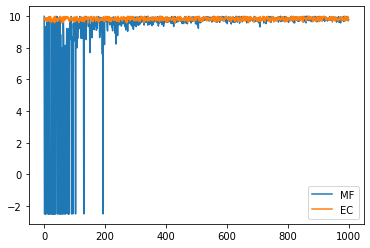

In [64]:
#plot results 
import matplotlib.pyplot as plt 
plt.plot(expt1.data['total_reward'], label='MF')
plt.plot(expt2.data['total_reward'], label='EC')
plt.legend(loc=0)
plt.show()